In [1]:
#importing relevant libraries & packages for analysis
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#loading the dataset
#worked with same dataset in another project, so I am already pretty familiar with its contents
df_original = pd.read_csv("Invistico_Airline.csv")

In [3]:
#viewing the dataset
df_original.head(10)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0
5,satisfied,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,...,2,2,5,4,5,5,4,2,0,0.0
6,satisfied,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,3,...,5,5,5,0,5,5,5,3,17,15.0
7,satisfied,Loyal Customer,10,Personal Travel,Eco,1812,0,0,0,3,...,2,2,3,3,4,5,4,2,0,0.0
8,satisfied,Loyal Customer,56,Personal Travel,Business,73,0,0,0,3,...,5,4,4,0,1,5,4,4,0,0.0
9,satisfied,Loyal Customer,22,Personal Travel,Eco,1556,0,0,0,3,...,2,2,2,4,5,3,4,2,30,26.0


In [4]:
#exploring the dataset
df_original.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
dtype: obj

In [5]:
#taking a peek at class column, suspect it is ordinal categorical variable considering context of airliner
df_original["Class"].unique()

array(['Eco', 'Business', 'Eco Plus'], dtype=object)

In [6]:
#checking satisfaction rates, determining if dataset is balanced or imbalanced
df_original['satisfaction'].value_counts(dropna = False)

satisfied       71087
dissatisfied    58793
Name: satisfaction, dtype: int64

In [7]:
#dataset is relatively balanced, 55% of customers reported satisfied
#value can be compared later relative to decision tree's model accuracy 
#regardless, checking for missing values
df_original.isnull().sum()

satisfaction                           0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

In [10]:
#checking shape of dataset for further exploratory analysis
df_original.shape

(129880, 22)

In [11]:
#dropping missing values like last time
df_subset = df_original.dropna(axis=0).reset_index(drop = True)

In [12]:
#checking shape of modified dataset
df_subset.shape

(129487, 22)

In [13]:
#confirming 393 observations were dropped
129880-129487

393

In [14]:
#decision trees need numeric data
#need to encode categorical information of satisfaction, customer type, type of travel, and class into numeric types
#dealing with class now
df_subset['Class'] = df_subset['Class'].map({"Business": 3, "Eco Plus": 2, "Eco": 1}) 

In [15]:
#dealing with satisfaction now
df_subset['satisfaction'] = df_subset['satisfaction'].map({"satisfied": 1, "dissatisfied": 0})

In [16]:
#creating dummy variables to deal with other categorical columns 
df_subset = pd.get_dummies(df_subset, drop_first = True)

In [17]:
#revisiting the dataset after wrangling procedures
#viewing column datatypes to confirm procedures were performed correctly
df_subset.dtypes

satisfaction                           int64
Age                                    int64
Class                                  int64
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
Customer Type_disloyal Customer        uint8
Type of Travel_Personal Travel         uint8
dtype: obj

In [18]:
#creating training and testing subsets of data for analysis
#random state is defined as zero for reproducability and best practice due dilligence
y = df_subset["satisfaction"]
X = df_subset.copy()
X = X.drop("satisfaction", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [19]:
#building the decision tree model
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train, y_train)
dt_pred = decision_tree.predict(X_test)

In [20]:
#printing metrics to evaluate decision tree model
print("Decision Tree")
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_test, dt_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_test, dt_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_test, dt_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_test, dt_pred))

Decision Tree
Accuracy: 0.935438
Precision: 0.942859
Recall: 0.939030
F1 Score: 0.940940


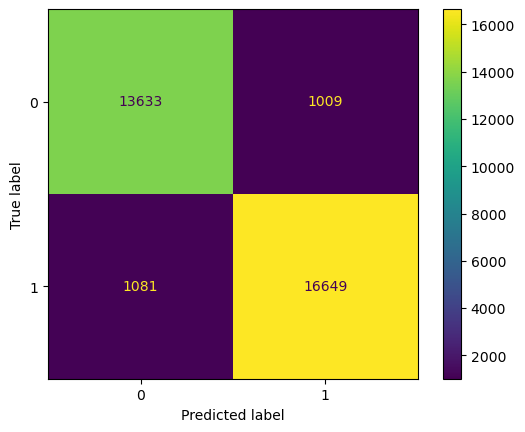

In [21]:
#metrics look remarkably good tbh 
#producing confusion matrix based off evaluation metrics aforementioned
#confusion matrix should give insight with respect to types of errors made by the decision tree algorithm
cm = metrics.confusion_matrix(y_test, dt_pred, labels = decision_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = decision_tree.classes_)
disp.plot()

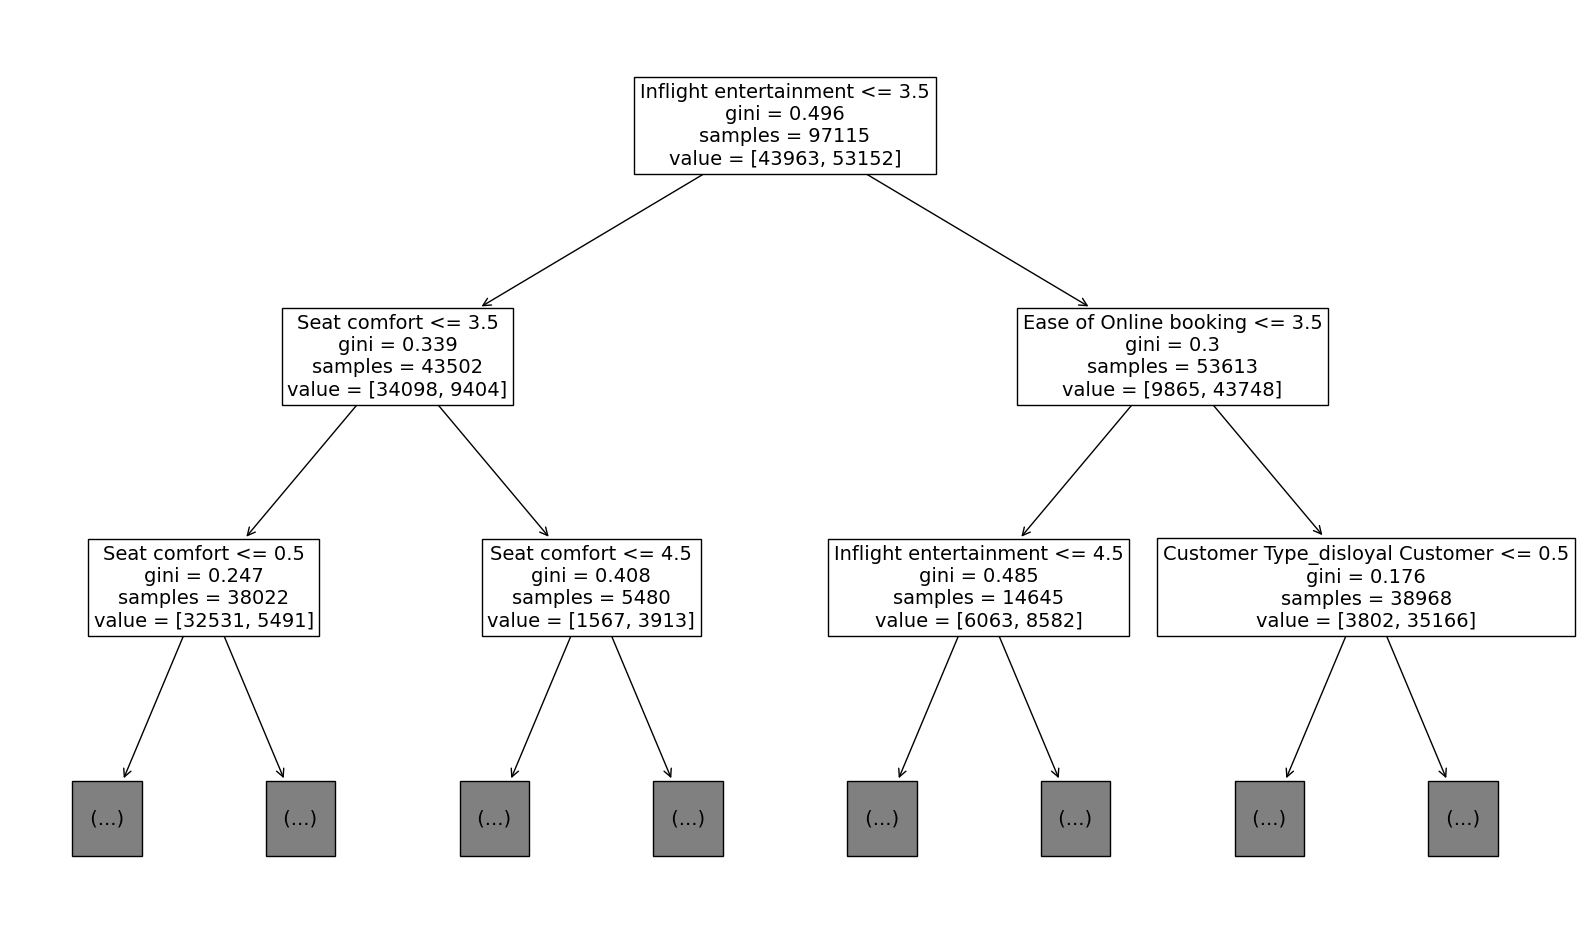

In [22]:
#relatively low number of flase positives and negatives, model is very promising 
#plotting the decision tree for visual inspection
plt.figure(figsize=(20,12))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns);

<Axes: >

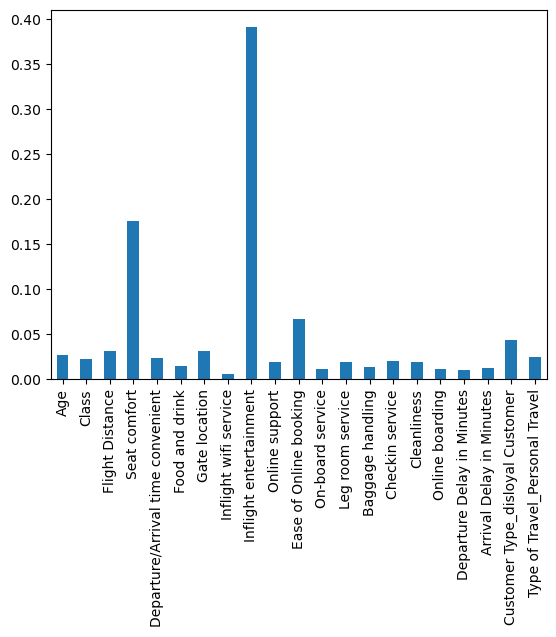

In [23]:
#creating feature importance graph to determine which features are most important to decision tree model
importances = decision_tree.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)

In [24]:
#from the visual, inflight entertainment (which i explored from previous exercise), seat comfort, and ease of online booking
#are most important features to determine satisfaction
#attempting to tune hyperparameters to increase model performance 
tree_para = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50],
             'min_samples_leaf': [2,3,4,5,6,7,8,9, 10, 15, 20, 50]}
scoring = {'accuracy', 'precision', 'recall', 'f1'}

In [25]:
#using GridSearch to examine which pair of max depth & min leaf has the best evaluation metrics
tuned_decision_tree = DecisionTreeClassifier(random_state=0)
clf = GridSearchCV(tuned_decision_tree, 
                   tree_para, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 30, 40,
                                       50],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15,
                                              20, 50]},
             refit='f1', scoring={'accuracy', 'f1', 'precision', 'recall'})

In [26]:
#computing the best combination of values for hyperparameters
clf.best_estimator_

DecisionTreeClassifier(max_depth=18, min_samples_leaf=2, random_state=0)

In [27]:
#best performing model: max depth 18, min leaf 2
#determining best average validation score
print("Best Avg. Validation Score: ", "%.4f" % clf.best_score_)

Best Avg. Validation Score:  0.9454


In [33]:
#best average validation score is nearly 95%
#determining evaluation metrics for best potential decision tree model
#i just copied this code, this code chunk goes a bit over my head given current knowledge
#i know what it does, but I couldn't possibly construct it on my own
results = pd.DataFrame(columns=['Model', 'F1', 'Recall', 'Precision', 'Accuracy'])

def make_results(model_name, model_object):
    """
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    """

    # Get all the results from the CV and put them in a df.
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score).
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row.
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create a table of results.
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                          'F1': f1,
                          'Recall': recall,
                          'Precision': precision,
                          'Accuracy': accuracy},
                         ignore_index=True)

    return table

result_table = make_results("Tuned Decision Tree", clf)

result_table

C:\Users\Cameron\AppData\Local\Temp\ipykernel_16788\554169781.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.945422,0.935863,0.955197,0.940864


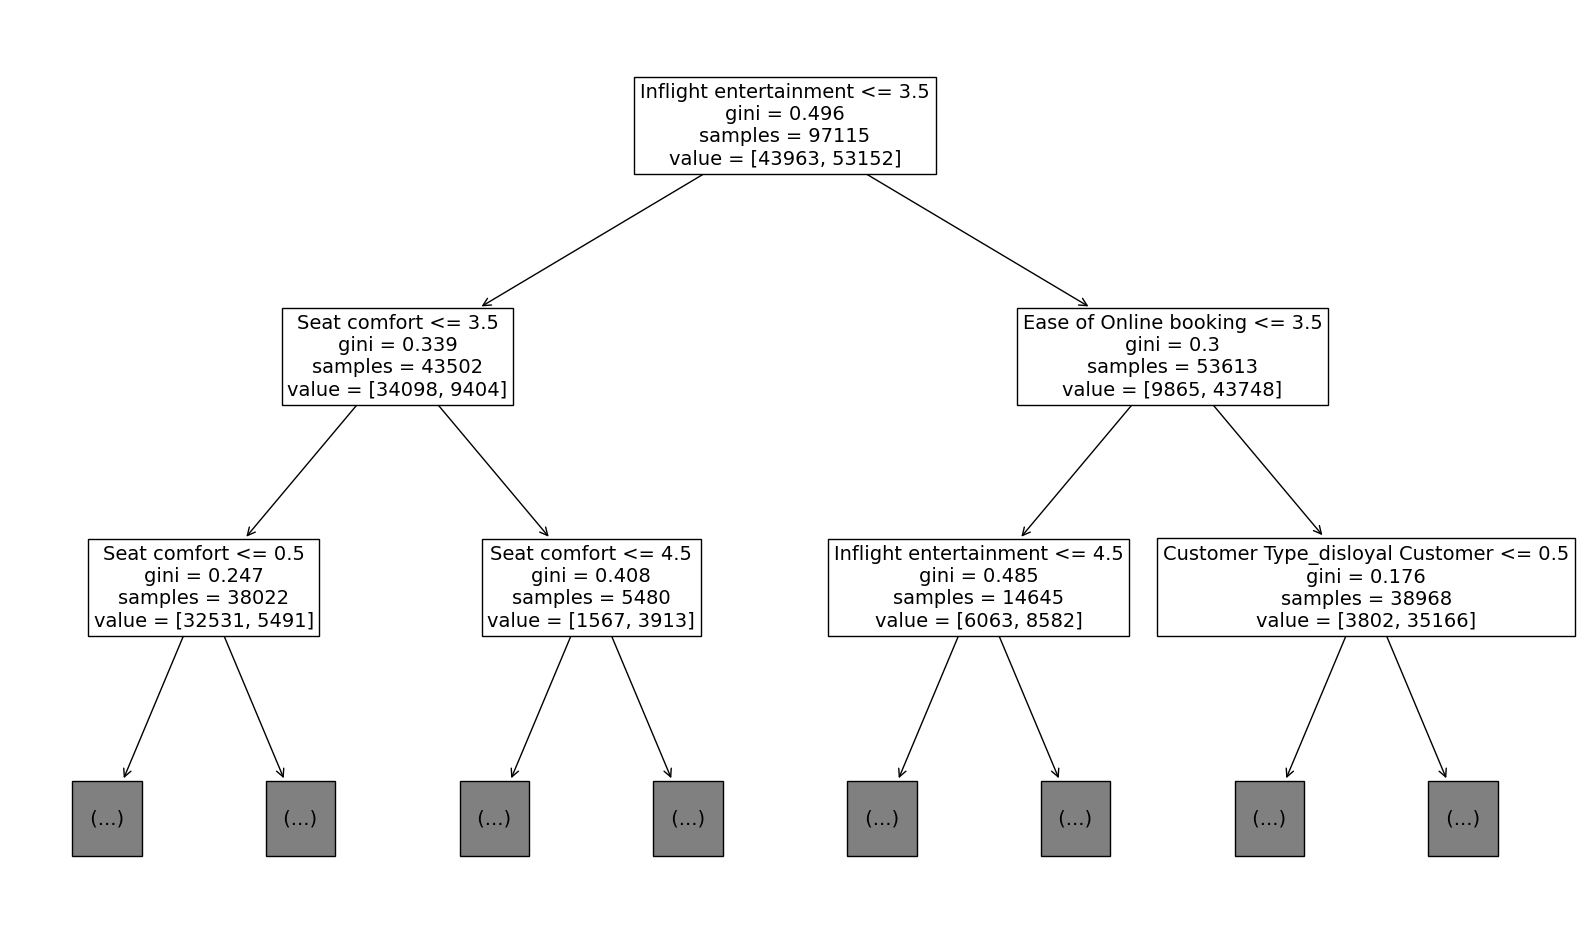

In [34]:
#F1 score barely improved, no meaningful difference in model improvement really unfortunately 
#plotting the "best" decision tree model as determine prior through GridSearch
plt.figure(figsize=(20,12))
plot_tree(clf.best_estimator_, max_depth=2, fontsize=14, feature_names=X.columns);

<Axes: >

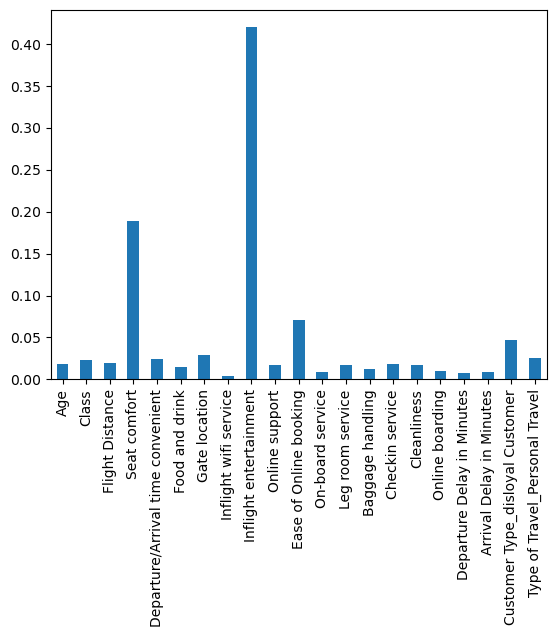

In [35]:
#building another feature importance gggraph to validate which features are most important
importances = clf.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)

In [ ]:
#confirms inflight entertainment, seat comfort, and ease of online booking are most important features relative to satisfaction